In [1]:
# %pip list | grep google-cloud-aiplatform
# %pip list | grep google-api-core
# %pip install google-cloud-aiplatform==1.43.0
# %pip install google-api-core==2.17.1

In [2]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, ChatSession, Part
import vertexai.preview.generative_models as generative_models

import geopandas as gp
from shapely.geometry import Point
import http.client
import json
import urllib.parse

In [3]:
import requests
import itertools
import numpy as np
import pandas as pd
import numpy.linalg
import vertexai

from google.api_core import retry
from vertexai.language_models import TextEmbeddingModel, TextGenerationModel
from tqdm.auto import tqdm
from bs4 import BeautifulSoup, Tag

tqdm.pandas()

In [4]:
pd.set_option('display.max_colwidth', 120)

In [5]:
vertexai.init(project = "adsp-capstone-property-pilot", location = "us-central1")

In [6]:
model = GenerativeModel("gemini-1.0-pro")
chat = model.start_chat()

def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)

In [7]:
# Test chat
prompt = "Hello."
print(get_chat_response(chat, prompt))

Hi there! How can I help you today?


## Data Prep

In [10]:
# neighborhood description file
neighborhood_info_path = '/home/jupyter/Kshitiz_Working/neighborhood_info_final.csv'
neighborhood_df = pd.read_csv(neighborhood_info_path)
# Add neighborhood name to the description
neighborhood_df['text'] = neighborhood_df['neighborhood'] + ' ' + neighborhood_df['neighborhood_information_scrapped'].apply(lambda x: ' '.join(eval(x)))

In [11]:
neighborhood_df.head()

,neighborhood,neighborhood_information,neighborhood_information_scrapped,text
0,Ravenswood,"Ravenswood in Chicago is celebrated for its robust craft beer scene, prominently featuring a collection of well-know...","['Chicagoans love craft beer, and with a slew of well-known breweries all in one area, you can bet we’re making a be...","Ravenswood Chicagoans love craft beer, and with a slew of well-known breweries all in one area, you can bet we’re ma..."
1,South Loop,The South Loop is a vibrant Chicago neighborhood known for its significant cultural attractions and lively entertain...,"['It’s home to the lakefront Museum Campus, where you’ll find three of Chicago’s biggest museums. Also in the South ...","South Loop It’s home to the lakefront Museum Campus, where you’ll find three of Chicago’s biggest museums. Also in t..."
2,Belmont Cragin,"Belmont Cragin, a neighborhood rich in Hispanic culture, is characterized by a close-knit community and a growing ar...",['This close-knit neighborhood is home to loads of Hispanic culture and a burgeoning arts community. Originally a ha...,Belmont Cragin This close-knit neighborhood is home to loads of Hispanic culture and a burgeoning arts community. Or...
3,Avondale,"Avondale is a neighborhood with a growing reputation for its vibrant dining and nightlife, attracting a diverse crow...","['An under-the-radar dining and nightlife scene is putting all eyes on Avondale, an area that many predict will be t...","Avondale An under-the-radar dining and nightlife scene is putting all eyes on Avondale, an area that many predict wi..."
4,Englewood,Englewood is a vibrant community known for its deep roots in Black music and culture. It hosts popular events like t...,"['Englewood is a large residential neighborhood known as a long-time hub for Black music and culture.', 'The area ho...",Englewood Englewood is a large residential neighborhood known as a long-time hub for Black music and culture. The ar...


In [12]:
all_text = neighborhood_df['text'].tolist()

In [13]:
len(all_text)

47

Document length distribution


array([[<Axes: title={'center': '0'}>]], dtype=object)

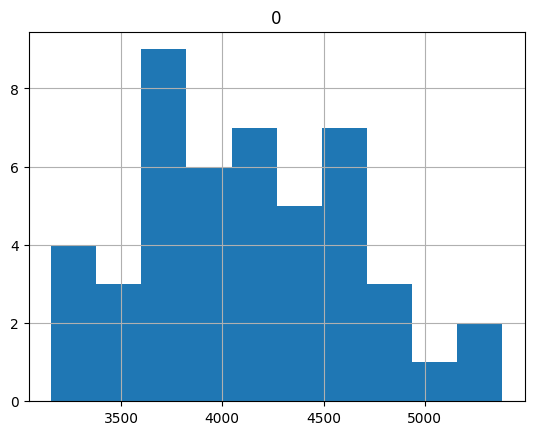

In [14]:
text_lengths = [len(t) for t in all_text]

print('Document length distribution')
pd.DataFrame(text_lengths).hist()

## Create vector store¶

In [19]:
embeddings_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

In [20]:
# Separates seq into multiple chunks in the specified size with the specified overlap
def split_overlap(seq, size, overlap):
    if len(seq) <= size:
        return [seq]
    return ["".join(x) for x in zip(*[seq[i :: size - overlap] for i in range(size)])]


# Compute the cosine similarity of two vectors, wrap as returned function to make easier to use with Pandas
def get_similarity_fn(query_vector):
    def fn(row):
        return np.dot(row, query_vector) / (
            numpy.linalg.norm(row) * numpy.linalg.norm(query_vector)
        )

    return fn

# Retrieve embeddings from the specified model with retry logic
@retry.Retry(timeout=300.0)
def get_embeddings(text):
    return embeddings_model.get_embeddings([text])[0].values

# Create the vector store, we are using a Pandas DataFrame
def create_vector_store(texts, chunk_size, overlap):
    vector_store = pd.DataFrame()
    # Insert the individual texts into the vector store
    vector_store["texts"] = list(
        itertools.chain(*[split_overlap(t, chunk_size, overlap) for t in texts])
    )

    # Create embeddings from those texts
    vector_store["embeddings"] = (
        vector_store["texts"].progress_apply(get_embeddings).apply(np.array)
    )

    return vector_store

In [46]:
%%time

CHUNK_SIZE = 400
OVERLAP = 50

vector_store = create_vector_store(all_text, CHUNK_SIZE, OVERLAP)

  0%|          | 0/527 [00:00<?, ?it/s]

CPU times: user 2.81 s, sys: 239 ms, total: 3.04 s
Wall time: 26.9 s


In [47]:
vector_store.head()

,texts,embeddings
0,"Ravenswood Chicagoans love craft beer, and with a slew of well-known breweries all in one area, you can bet we’re ma...","[-0.015725474804639816, -0.04845630005002022, 0.014403422363102436, 0.054341886192560196, 0.0034469428937882185, -0...."
1,"Sample some brews at laidback Begyle Brewing, Old-World-inspired Dovetail Brewery, and botanical-focused Forbidden R...","[-0.01855381578207016, -0.012325075455009937, 0.04381750524044037, 0.028196951374411583, -0.01702563278377056, -0.01..."
2,"aff. Grab a bite: After all that beer, you’re going to want something to eat. Spacca Napoli Pizzeria is known for it...","[-0.007087345700711012, -0.028249159455299377, 0.015769869089126587, 0.01621190272271633, -0.010161901824176311, -0...."
3,iscover the neighborhood’s cool mix of urban and family-friendly. Artifact Events hosts a full calendar of public ev...,"[-0.023173771798610687, -0.0009359957766719162, -0.021764786913990974, 0.018287889659404755, -0.008924626745283604, ..."
4,"lass. Or take a walk through sprawling Winnemac Park, one of the area’s many green spaces. Taste, shop and explore t...","[-0.02770255133509636, -0.020968427881598473, 0.018577206879854202, 0.07044970989227295, -0.01204716507345438, 0.049..."


In [48]:
# embedding to str
vector_store['embeddings'] = vector_store['embeddings'].apply(lambda x: ','.join(map(str, x)))
# save csv
vector_store.to_csv('/home/jupyter/property_pilot/data/vector_store.csv', index=False)

In [49]:
# read csv
vector_store = pd.read_csv('/home/jupyter/property_pilot/data/vector_store.csv')
# embedding to numpy array
vector_store['embeddings'] = vector_store['embeddings'].apply(lambda x: np.array(list(map(float, x.split(',')))))

In [50]:
vector_store.head()

,texts,embeddings
0,"Ravenswood Chicagoans love craft beer, and with a slew of well-known breweries all in one area, you can bet we’re ma...","[-0.015725474804639816, -0.04845630005002022, 0.014403422363102436, 0.054341886192560196, 0.0034469428937882185, -0...."
1,"Sample some brews at laidback Begyle Brewing, Old-World-inspired Dovetail Brewery, and botanical-focused Forbidden R...","[-0.01855381578207016, -0.012325075455009937, 0.04381750524044037, 0.028196951374411583, -0.01702563278377056, -0.01..."
2,"aff. Grab a bite: After all that beer, you’re going to want something to eat. Spacca Napoli Pizzeria is known for it...","[-0.007087345700711012, -0.028249159455299377, 0.015769869089126587, 0.01621190272271633, -0.010161901824176311, -0...."
3,iscover the neighborhood’s cool mix of urban and family-friendly. Artifact Events hosts a full calendar of public ev...,"[-0.023173771798610687, -0.0009359957766719162, -0.021764786913990974, 0.018287889659404755, -0.008924626745283604, ..."
4,"lass. Or take a walk through sprawling Winnemac Park, one of the area’s many green spaces. Taste, shop and explore t...","[-0.02770255133509636, -0.020968427881598473, 0.018577206879854202, 0.07044970989227295, -0.01204716507345438, 0.049..."


In [51]:
type(vector_store['embeddings'][0])

numpy.ndarray

## Instructing the model to only use text retrieved from vector store for answer generation¶

In [53]:
def get_context(question, vector_store, num_docs):
    # Embed the search query
    query_vector = np.array(get_embeddings(question))

    # Get similarity to all other vectors and sort, cut off at num_docs
    top_matched = (
        vector_store["embeddings"]
        .apply(get_similarity_fn(query_vector))
        .sort_values(ascending=False)[:num_docs]
        .index
    )
    top_matched_df = vector_store[vector_store.index.isin(top_matched)][["texts"]]

    # Return a string with the top matches
    context = " ".join(top_matched_df.texts.values)
    return context

In [54]:
user_query = 'Tell me about South Loop.'
context = get_context(question = user_query, vector_store=vector_store, num_docs=10)
print(context)

South Loop It’s home to the lakefront Museum Campus, where you’ll find three of Chicago’s biggest museums. Also in the South Loop, you’ll find celebrated jazz clubs, a mix of crowd-pleasing restaurants, and vibrant historic areas like industrial Motor Row and charming the Prairie Avenue District. It’s a little mind-blowing arriving on the site of Chicago’s Museum Campus. The three gorgeous neoclas , now an entertainment destination with the colorful Lips Drag Palace, VU Rooftop bar, Duneyrr Fermenta brewery, and more. In the nearby Prairie Avenue District, you can stroll “Millionaire’s Row,” lined with mansions that once belonged to Chicago’s elite, including the historic Glessner House museum. The South Loop is also home to Soldier Field, which means you’ll find plenty of Bears fans here i r Field Soldier Field Soldier Field See all events in South Loop Discover more in South Loop With trendy restaurants, cozy coffee shops, cocktail bars and shops on just about every corner, there’s e

In [22]:
def generate_prompt_rag_neighborhood(instruction, context, user_query):
    instruction = instruction.replace("{CONTEXT}", context)
    return instruction.replace("{USER_QUERY}", user_query)

In [23]:
instruction_rag_neighborhood = """
### Instructions ###
You will act as a local neighborhood advisor to answer the question described in the 'User's query' below.
Your mission is to provide answers based on the given 'Context' below. Before responding, ensure that your answer complies with your mission.
Only provide information from the context. If the information is not in the context, respond with "I don't know the answer to that."

### User’s query ###
{USER_QUERY}

### Context ###
{CONTEXT}

### Output ###
"""

In [24]:
# Example
prompt_rag_neighborhood = generate_prompt_rag_neighborhood(instruction_rag_neighborhood, context, user_query)
print(prompt_rag_neighborhood)


### Instructions ###
You will act as a local neighborhood advisor to answer the question described in the 'User's query' below.
Your mission is to provide answers based on the given 'Context' below. Before responding, ensure that your answer complies with your mission.
Only provide information from the context. If the information is not in the context, respond with "I don't know the answer to that."

### User’s query ###
Tell me about South Loop.

### Context ###
South Loop It’s home to the lakefront Museum Campus, where you’ll find three of Chicago’s biggest museums. Also in the South Loop, you’ll find celebrated jazz clubs, a mix of crowd-pleasing restaurants, and vibrant historic areas like industrial Motor Row and charming the Prairie Avenue District. It’s a little mind-blowing arriving on the site of Chicago’s Museum Campus. The three gorgeous neoclas , now an entertainment destination with the colorful Lips Drag Palace, VU Rooftop bar, Duneyrr Fermenta brewery, and more. In the 

## Test - without context

In [25]:
user_query = 'Tell me about South Loop.'
print(get_chat_response(chat, user_query))

## The South Loop: A Diverse and Dynamic Chicago Neighborhood 

The South Loop is a vibrant and rapidly changing neighborhood located just south of Chicago's Loop, the city's central business district. Once an industrial area, the South Loop has undergone a significant transformation in recent decades, evolving into a thriving residential and commercial hub. 

Here's a glimpse into the South Loop:

**Location and Boundaries:** 

- Bordered by the Chicago River to the north, Roosevelt Road to the south, the South Branch of the Chicago River to the west, and Lake Michigan to the east.
- Easily accessible via public transportation, with several CTA train and bus lines running through the area.

**Character and Vibe:** 

- A mix of historic and modern architecture, with many converted loft buildings and new high-rise developments. 
- Lively atmosphere, with a diverse population of young professionals, families, and students. 
- Growing culinary scene, boasting trendy restaurants, cafes, an

In [26]:
user_query = 'Tell me about Hyde Park'
print(get_chat_response(chat, user_query))

## Exploring Hyde Park: A Chicago Gem

Hyde Park is a historic and vibrant neighborhood on the South Side of Chicago, Illinois. It's renowned for its beautiful architecture, world-class educational institutions, and diverse cultural offerings. Let's delve into what makes Hyde Park so special:

**Location and Character:**

* Situated along the shores of Lake Michigan, Hyde Park offers stunning lakefront views and easy access to the lakefront trail for walking, biking, and rollerblading.
* The neighborhood boasts a mix of architectural styles, including grand mansions, charming cottages, and modern high-rises. 
* Hyde Park is home to a vibrant community with a strong sense of history and tradition.

**Educational Hub:**

* The University of Chicago, a world-renowned institution, is the heart of Hyde Park. Its beautiful campus and intellectual atmosphere contribute significantly to the neighborhood's character.
* The presence of the university attracts renowned scholars, researchers, and 

In [27]:
user_query = 'Tell me about streeterville.'
print(get_chat_response(chat, user_query))

## Unveiling Streeterville: A Vibrant Chicago Heart

Streeterville is a thriving neighborhood located along the Magnificent Mile in downtown Chicago, offering a blend of luxury living, world-class entertainment, and breathtaking views of Lake Michigan. Let's explore what makes Streeterville a standout destination:

**Location and Character:**

* Situated between the Chicago River and Lake Michigan, Streeterville offers stunning waterfront views and easy access to the scenic lakefront trail.
* The neighborhood boasts a mix of high-rise residential buildings, luxury hotels, and renowned cultural institutions.
* Streeterville exudes a vibrant and upscale atmosphere, attracting both residents and visitors seeking a sophisticated urban experience.

**Entertainment and Attractions:**

* The iconic Navy Pier, with its Ferris wheel, amusement park rides, shops, and restaurants, is a major attraction in Streeterville.
* The Museum of Contemporary Art Chicago showcases thought-provoking exhibiti

## Test - with context

In [28]:
user_query = 'Tell me about South Loop.'
context = get_context(question = user_query, vector_store=vector_store, num_docs=10)
prompt_rag_neighborhood = generate_prompt_rag_neighborhood(instruction_rag_neighborhood, context, user_query)
print('####Context:####', context)
print('####Final response####', get_chat_response(chat, prompt_rag_neighborhood))

####Context:#### South Loop It’s home to the lakefront Museum Campus, where you’ll find three of Chicago’s biggest museums. Also in the South Loop, you’ll find celebrated jazz clubs, a mix of crowd-pleasing restaurants, and vibrant historic areas like industrial Motor Row and charming the Prairie Avenue District. It’s a little mind-blowing arriving on the site of Chicago’s Museum Campus. The three gorgeous neoclas , now an entertainment destination with the colorful Lips Drag Palace, VU Rooftop bar, Duneyrr Fermenta brewery, and more. In the nearby Prairie Avenue District, you can stroll “Millionaire’s Row,” lined with mansions that once belonged to Chicago’s elite, including the historic Glessner House museum. The South Loop is also home to Soldier Field, which means you’ll find plenty of Bears fans here i r Field Soldier Field Soldier Field See all events in South Loop Discover more in South Loop With trendy restaurants, cozy coffee shops, cocktail bars and shops on just about every 

In [29]:
user_query = 'Tell me about Hyde Park'
context = get_context(question = user_query, vector_store=vector_store, num_docs=10)
prompt_rag_neighborhood = generate_prompt_rag_neighborhood(instruction_rag_neighborhood, context, user_query)
print('####Context:####', context)
print('####Final response####', get_chat_response(chat, prompt_rag_neighborhood))

####Context:#### Hyde Park  It was the site of the Chicago World’s Fair of 1893, home to former President Barack Obama, an incubator for Nobel Prize winners — basically, history is made in Hyde Park. Get hands-on at the science museum: This culturally rich neighborhood is bookended by two of the city’s most significant institutions — the University of Chicago to the west and the Museum of Science and Industry to t  and culture: Also near Hyde Park, the DuSable Black History Museum is the country’s first institution dedicated to African American history and culture. It resides within Washington Park, home to a bird and butterfly sanctuary and the much-photographed Fountain of Time. And the Hyde Park Art Center has been a powerhouse on the art scene for more than 70 years, claiming the title of oldest alterna Theatre See all events in Hyde Park Discover more in Hyde Park With trendy restaurants, cozy coffee shops, cocktail bars and shops on just about every corner, there’s endless ways t

In [30]:
user_query = 'Tell me about streeterville.'
context = get_context(question = user_query, vector_store=vector_store, num_docs=10)
prompt_rag_neighborhood = generate_prompt_rag_neighborhood(instruction_rag_neighborhood, context, user_query)
print('####Context:####', context)
print('####Final response####', get_chat_response(chat, prompt_rag_neighborhood))

####Context:#### American life and culture. Northalsted (also known as Boystown) is known around the world as the oldest official recognized gay neighborhood in the country. This eclectic quality gives this neighborhood a small-town feel in the middle of a big, dynamic city. If you’re looking for a good time, look no further than Wrigleyville. You'll find lively sports bars, cool new restaurants, and (of course) t story, notable residents, and legacy as a hub for African American life and culture. Northalsted (also known as Boystown) is known around the world as the oldest official recognized gay neighborhood in the country. This eclectic quality gives this neighborhood a small-town feel in the middle of a big, dynamic city. If you’re looking for a good time, look no further than Wrigleyville. You'll find l Wrigleyville Wrigleyville is home to historic Wrigley Field, the second oldest ballpark in the country. Whether or not you’re a sports fan, you can’t help catching a little Cubs fev